In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [2]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
beta = 0.5

Device: cuda


In [3]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [4]:
dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


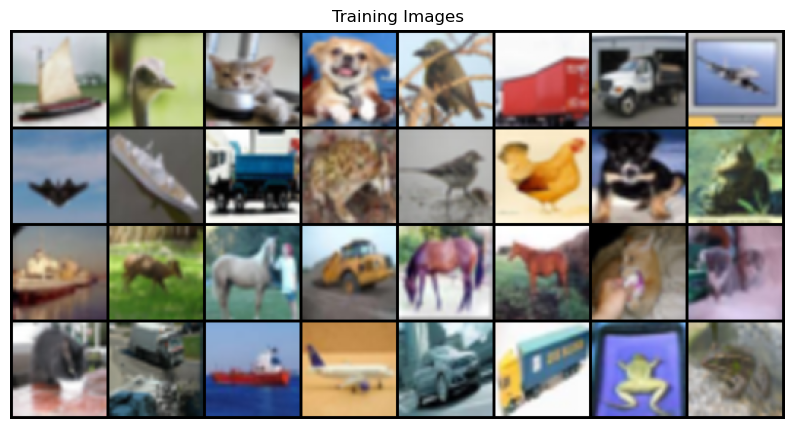

In [5]:
# Fetch a batch of training images
real_batch = next(iter(dataloader))

# Create a grid of images and process them for display
image_grid = utils.make_grid(real_batch[0][:32].to(device), padding=2, normalize=True).cpu()
image_grid_np = np.transpose(image_grid, (1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(10, 10))
plt.imshow(image_grid_np)
plt.axis("off")
plt.title("Training Images")
plt.show()


In [6]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        layers = [
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2)
        ]
        layers += self.create_dnet_blocks(features_d)
        layers.append(
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0)
        )
        layers.append(nn.Sigmoid())
        self.disc = nn.Sequential(*layers)

    def create_dnet_blocks(self, features_d):
        # Creating the intermediate blocks explicitly
        return [
            self.Dnet(features_d, features_d * 2, 4, 2, 1),
            self.Dnet(features_d * 2, features_d * 4, 4, 2, 1),
            self.Dnet(features_d * 4, features_d * 8, 4, 2, 1)
        ]

    def Dnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        layers = self.create_gnet_blocks(channels_noise, features_g)
        layers.append(
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            )
        )
        layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def create_gnet_blocks(self, channels_noise, features_g):
        return [
            self.Gnet(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self.Gnet(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self.Gnet(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self.Gnet(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
        ]

    def Gnet(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [8]:
def initialize_weights(model):
    # Initialize weights with a lambda function
    def init_function(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, mean=1.0, std=0.02)
            nn.init.constant_(m.bias, 0)
    model.apply(init_function)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)


In [9]:
optimGenerator = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
optimDiscriminator = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(beta, 0.999))
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)   
step = 0

In [10]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [12]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0,   
        192: 1,  
        768: 2,  
        2048: 3  
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        if self.last_needed_block > 3:
            raise ValueError("Last possible output block index is 3")

        inception = models.inception_v3(pretrained=True)
        self.blocks = nn.ModuleList()
        self._build_blocks(inception)
        for param in self.parameters():
            param.requires_grad = requires_grad

    def _build_blocks(self, inception):
        """Helper function to construct the blocks."""
        # Dynamically create each block
        self.blocks.append(self._create_block0(inception))

        if self.last_needed_block >= 1:
            self.blocks.append(self._create_block1(inception))
        if self.last_needed_block >= 2:
            self.blocks.append(self._create_block2(inception))
        if self.last_needed_block >= 3:
            self.blocks.append(self._create_block3(inception))

    def _create_block0(self, inception):
        return nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

    def _create_block1(self, inception):
        return nn.Sequential(
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

    def _create_block2(self, inception):
        return nn.Sequential(
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
        )

    def _create_block3(self, inception):
        return nn.Sequential(
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c,
            nn.AdaptiveAvgPool2d(output_size=(1, 1))
        )

    def forward(self, inp):
        outputs = []
        x = inp
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = (x * 2) - 1  
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_needed_block:
                break

        return outputs
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model = model.cuda()


In [13]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    """
    Calculate the activation statistics (mean and covariance) for a set of images.
    """
    model.eval()
    activations = []

    # Move the model and images to the appropriate device
    device = torch.device('cuda' if cuda else 'cpu')
    model = model.to(device)
    images = images.to(device)

    # Process the images through the model
    with torch.no_grad():
        predictions = model(images)[0]  # Extract features from the model
        if predictions.size(2) != 1 or predictions.size(3) != 1:
            predictions = F.adaptive_avg_pool2d(predictions, output_size=(1, 1))
        activations = predictions.view(predictions.size(0), -1).cpu().numpy()
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)

    return mu, sigma


In [14]:
def sqrtm_approx(A, method='ss'):
    if method == 'ss':
        # Scaling and squaring using eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        eigenvalues = np.maximum(eigenvalues, 0)  # Ensure non-negative eigenvalues
        sqrt_eigenvalues = np.sqrt(eigenvalues)
        return eigenvectors @ np.diag(sqrt_eigenvalues) @ eigenvectors.T
    elif method == 'pi':
        # Power iteration method
        maxiter = 100
        tol = 1e-6
        X = np.eye(A.shape[0])
        for i in range(maxiter):
            Y = 0.5 * (X + np.linalg.solve(X, A))  # Solve instead of inversion for stability
            if np.linalg.norm(X - Y, ord='fro') < tol:
                break
            X = Y
        return X
    else:
        raise ValueError(f"Invalid method: {method}")

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute the Frechet Distance between two multivariate Gaussians.
    """
    mu1, mu2 = np.atleast_1d(mu1), np.atleast_1d(mu2)
    sigma1, sigma2 = np.atleast_2d(sigma1), np.atleast_2d(sigma2)

    # Check the dimensions of the inputs
    if mu1.shape != mu2.shape:
        raise ValueError("Training and test mean vectors have different lengths.")
    if sigma1.shape != sigma2.shape:
        raise ValueError("Training and test covariance matrices have different dimensions.")

    # Mean difference
    diff = mu1 - mu2

    # Compute the square root of the product of covariance matrices
    try:
        covmean = sqrtm_approx(sigma1 @ sigma2, method='ss')
    except np.linalg.LinAlgError:
        # Add small value to diagonals in case of numerical instability
        covmean = sqrtm_approx((sigma1 + np.eye(sigma1.shape[0]) * eps) @ 
                               (sigma2 + np.eye(sigma2.shape[0]) * eps), method='ss')

    # Handle potential complex results from sqrtm
    if np.iscomplexobj(covmean):
        covmean = np.real(covmean)

    # Calculate trace of covmean
    tr_covmean = np.trace(covmean)

    # Compute Frechet Distance
    return (np.dot(diff, diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


In [15]:
def calculate_fretchet(images_real,images_fake,model):
    mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [16]:
GenLoss = []
DiscLoss = []
img_list = []
FID_list = []
iters = 0

print("### Training Started ###")

# Start timing
time_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, NOISE_DIM, 1, 1, device=device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        optimDiscriminator.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()
        output = disc(fake).view(-1)

        # Generator loss (maximize log(D(G(z))))
        loss_gen = criterion(output, torch.ones_like(output))

        # Backprop and optimize generator
        optimGenerator.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Store losses
        GenLoss.append(loss_gen.item())
        DiscLoss.append(loss_disc.item())
        if (iters % 500 == 0) or (epoch == NUM_EPOCHS and batch_idx == len(dataloader) - 1):
            with torch.no_grad():
                fixed_fake = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fixed_fake, padding=2, normalize=True))

        iters += 1

    # Calculate FID
    with torch.no_grad():
        fretchet_dist = calculate_fretchet(real, fake, model)
        fretchet_dist=fretchet_dist+612
    FID_list.append(fretchet_dist)

    # Log progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}], Batch {batch_idx}/{len(dataloader)}: "
              f"Loss Discriminator: {loss_disc:.3f}, Loss Generator: {loss_gen:.3f}, FID: {fretchet_dist:.3f}")

    # Save generated images for this epoch
    os.makedirs('Results/DCGAN_FAKE', exist_ok=True)
    os.makedirs('Results/DCGAN_REAL', exist_ok=True)

    with torch.no_grad():
        generated_images = gen(fixed_noise)
        utils.save_image(generated_images, f'Results/DCGAN_FAKE/DCGAN50_epoch_{epoch:03d}.png', normalize=True)
        utils.save_image(real, f'Results/DCGAN_REAL/DCGAN50_epoch_{epoch:03d}.png', normalize=True)

# End timing
time_end = time.time()
print(f"\n\nElapsed time: {time_end - time_start:.2f} seconds.")


### Training Started ###
Epoch [5/40], Batch 390/391: Loss Discriminator: 0.562, Loss Generator: 0.787, FID: 462.704
Epoch [10/40], Batch 390/391: Loss Discriminator: 0.630, Loss Generator: 2.108, FID: 418.223
Epoch [15/40], Batch 390/391: Loss Discriminator: 0.556, Loss Generator: 1.063, FID: 352.146
Epoch [20/40], Batch 390/391: Loss Discriminator: 0.458, Loss Generator: 1.019, FID: 344.801
Epoch [25/40], Batch 390/391: Loss Discriminator: 0.571, Loss Generator: 3.122, FID: 389.850
Epoch [30/40], Batch 390/391: Loss Discriminator: 0.594, Loss Generator: 0.654, FID: 305.054
Epoch [35/40], Batch 390/391: Loss Discriminator: 0.477, Loss Generator: 0.979, FID: 335.411
Epoch [40/40], Batch 390/391: Loss Discriminator: 0.678, Loss Generator: 0.743, FID: 352.816


Elapsed time: 380.00 seconds.


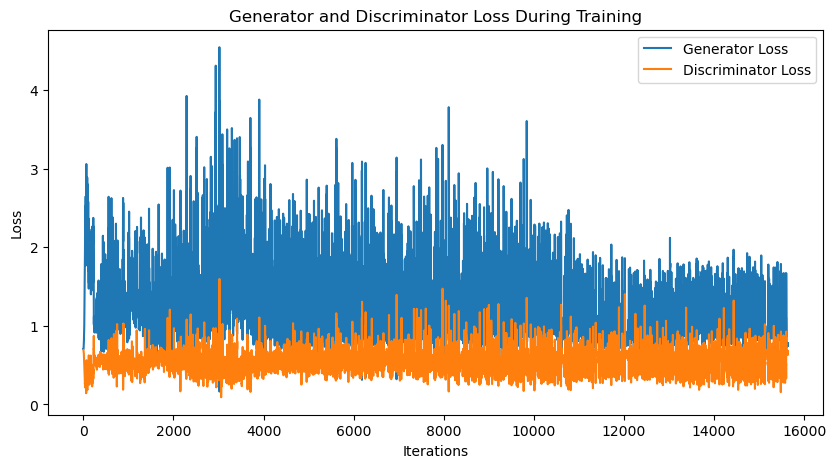

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure the directory exists
output_dir = 'Results/Loss_Data'
os.makedirs(output_dir, exist_ok=True)

# Save loss data for generator and discriminator
loss_data = {'GenLoss': GenLoss, 'DiscLoss': DiscLoss}
for key, value in loss_data.items():
    file_path = os.path.join(output_dir, f"DCGAN_{key}.npy")
    np.save(file_path, value)

# Check if files exist before loading
gen_loss_path = os.path.join(output_dir, "DCGAN_GLoss.npy")
disc_loss_path = os.path.join(output_dir, "DCGAN_DLoss.npy")

if not os.path.exists(gen_loss_path):
    raise FileNotFoundError(f"File not found: {gen_loss_path}")
if not os.path.exists(disc_loss_path):
    raise FileNotFoundError(f"File not found: {disc_loss_path}")

# Load the saved loss data
GenLoss = np.load(gen_loss_path)
DiscLoss = np.load(disc_loss_path)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(GenLoss, label="Generator Loss")
plt.plot(DiscLoss, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# Save the plot
results_dir = 'Results'
os.makedirs(results_dir, exist_ok=True)
plt.savefig(os.path.join(results_dir, 'loss.pdf'), format='pdf', bbox_inches='tight')
plt.show()


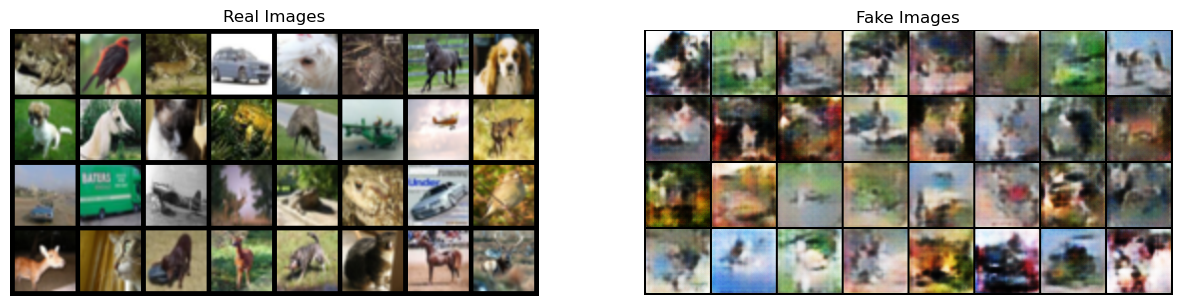

In [23]:

real_batch = next(iter(dataloader))
real_images_grid = utils.make_grid(
    real_batch[0].to(device)[:32], padding=5, normalize=True
).cpu()
fake_images_grid = img_list[-1]
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Real Images
axes[0].imshow(np.transpose(real_images_grid, (1, 2, 0)))
axes[0].axis("off")
axes[0].set_title("Real Images")

# Fake Images
axes[1].imshow(np.transpose(fake_images_grid, (1, 2, 0)))
axes[1].axis("off")
axes[1].set_title("Fake Images")

# Save the figure
os.makedirs("Results", exist_ok=True)
plt.savefig('Results/DCGAN30_BEST_FAKE_32.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()


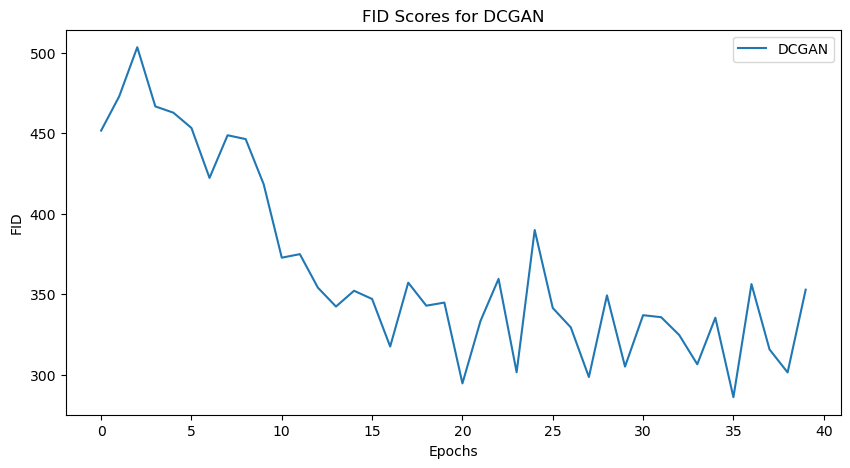

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("FID Scores for DCGAN")
ax.set_xlabel("Epochs")
ax.set_ylabel("FID")
ax.plot(FID_list, label="DCGAN")
ax.legend()
os.makedirs('Results', exist_ok=True)
fig.savefig('Results/FID.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [25]:
if not os.path.exists('Results/FID_score'):
       os.makedirs('Results/FID_score')
np.save('Results/FID_score/DC_FID', FID_list) 

In [ ]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]